# Import libraries

In [1]:
import jupyros as jr
import rospy
import ipywidgets as widgets
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox
from matplotlib import pyplot as plt

import actionlib
import actionlib.msg
import assignment_2_2022.msg
from nav_msgs.msg import Odometry
from assignment_2_2022.msg import Pos_and_Vel
from assignment_2_2022.srv import Num_Goal_rc, Num_Goal_rcResponse
from sensor_msgs.msg import LaserScan


import tf
from tf.transformations import quaternion_matrix
import numpy as np
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib as mpl

# Variables and initialization Node A

In [2]:
global goal
global client
global publisher
global msg
global num_c
global num_r

x_plot = []
y_plot = []

#initialize the node
rospy.init_node('RT2_nodeA')

# Set Publisher  on the topic /pos_and_vel

In [3]:
publisher = rospy.Publisher("/pos_and_vel", Pos_and_Vel, queue_size = 10)

# Callback function

In [4]:
def callback(msg):
    
    global x_plot, y_plot
    # Fill the matrix plot with the coordinates
    x_plot.append(msg.pose.pose.position.x)
    y_plot.append(msg.pose.pose.position.y)
    
    pos_vel = Pos_and_Vel()
    
    pos_vel.pos_x = msg.pose.pose.position.x
    pos_vel.pos_y = msg.pose.pose.position.y
    pos_vel.vel_x = msg.twist.twist.linear.x
    pos_vel.vel_y = msg.twist.twist.linear.y
    
    publisher.publish(pos_vel)

# Set Subscriber to the topic /odom

In [5]:
jr.subscribe("/odom", Odometry, callback)

# Set Action Client 

In [6]:
client = actionlib.SimpleActionClient('/reaching_goal', assignment_2_2022.msg.PlanningAction)

#wait for server
client.wait_for_server()

True

# Setting interface for setting/canceling goal

In [7]:
goal = assignment_2_2022.msg.PlanningGoal()

# Goal coordinates
x = widgets.FloatSlider(value=0 ,min=-10, max=10,step=0.5, description = "x:", orientation='horizontal')
y = widgets.FloatSlider(value=0 ,min=-10, max=10,step=0.5, description = "y:", orientation='horizontal')

# Widgets Buttons
send_button = Button(description='Send goal',tooltip='Send goal',layout=Layout(width='50%', height='100px', grid_area='b1'),button_style='info')
cancel_button = Button(description='Cancel goal',tooltip='Cancel goal',layout=Layout(width='50%',height='100px', grid_area='b2'),button_style='danger')


# if send button is clicked 
def on_button_send_clicked(b):
    
    goal.target_pose.pose.position.x = x.value
    goal.target_pose.pose.position.y = y.value
    
    #update goal list
    goal_list.value = goal_list.value + "Goal x: " + str(x.value) + "  y: " + str(y.value) + "\n"
    
    #send the goal returned by set_goal()
    client.send_goal(goal)
    
    x.disabled = True
    y.disabled = True
    send_button.disabled = True
    cancel_button.disabled = False
    

send_button.on_click(on_button_send_clicked)


def on_cancel_button_clicked(b):
    client.cancel_goal()
    
cancel_button.on_click(on_cancel_button_clicked)
        

# Result function and widget

In [9]:
def update_num(num_r, num_c):
    
    goal_list.value = goal_list.value +  str(num_c)+ "  Goal cancelled!\n"
    goal_list.value = goal_list.value +  str(num_r)+ "  Goal reached!\n"

In [10]:
def checkGoalResult(msg):
    global num_c, num_r
    
    # Get the status 
    status = msg.status.status

    # If status is 2 the goal is canceled
    if status == 2:
        
        num_c = num_c + 1
        
        x.disabled = False
        y.disabled = False
        
        send_button.disabled = False
        cancel_button.disabled = True
        
        

    # If status is 3 the goal is reached
    elif status == 3:
        
        num_r = num_r + 1
        
        x.disabled = False
        y.disabled = False
        
        send_button.disabled = False
        cancel_button.disabled = True
        
        

    update_num(num_r, num_c)
    
num_r, num_c = 0,0

# Set Subscriber for result

In [11]:
jr.subscribe("/reaching_goal/result", assignment_2_2022.msg.PlanningActionResult, checkGoalResult)

# Laser function

In [16]:
dmin = widgets.FloatText(description = "Distance:", disabled = True)
ang = widgets.FloatText(description = "Angle:", disabled = True)

def laserCallback(scan):
    min_range = 100
    angle = 100
    for at, x in enumerate(scan.ranges):
        if x < min_range and x > scan.range_min:
            min_range = x
            angle = scan.angle_min + scan.angle_increment * at
    
    dmin.value = min_range
    ang.value = angle


# Set Subscriber to /scan topic

In [17]:
jr.subscribe('/scan', LaserScan, laserCallback)

# All the widgets

In [12]:
widgets.HBox([widgets.VBox([x, y]), widgets.HBox([send_button, cancel_button])])

In [13]:
goal_list = widgets.Textarea(value = "Goal list:\n", disabled = True, style = dict(text_color = 'red') )

display(goal_list)

Textarea(value='Goal list:\n', disabled=True)

In [18]:
widgets.HBox([dmin, ang], description = "Distance from obstacle")

# Live pos and vel

In [19]:
posx = widgets.FloatText(description = "Pos x:", disabled = True)
posy = widgets.FloatText(description = "Pos y:", disabled = True)
velx = widgets.FloatText(description = "Vel x:", disabled = True)
vely = widgets.FloatText(description = "Vel y:", disabled = True)
    
widgets.HBox([widgets.VBox([posx, posy]), widgets.VBox([velx, vely])])

In [20]:
class Visualiser:
    
    def __init__(self):
        self.x_data, self.y_data = [] , []
    
    def vis_callback(self, data):
        self.y_data.append(data.pos_y)
        self.x_data.append(data.pos_x)
        posx.value = data.pos_x
        posy.value = data.pos_y
        velx.value = data.vel_x
        vely.value = data.vel_y
        
    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln

In [21]:
vis = Visualiser()
sub = jr.subscribe('/pos_and_vel', Pos_and_Vel, vis.vis_callback)


# Movement graph

Text(0, 0.5, 'y')

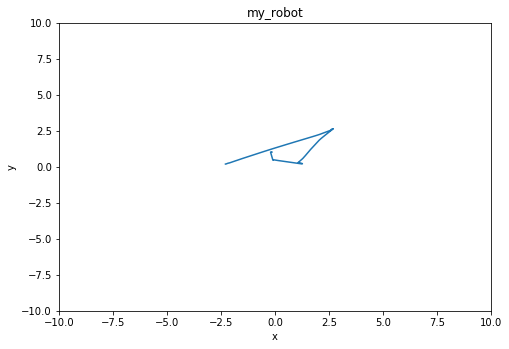

In [23]:
np_x_plot = np.array(x_plot) # sometimes may happen that array x and y have different dimension and plot doesn't work
np_y_plot = np.array(y_plot)

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.plot(np_x_plot,np_y_plot)
ax.set_title("my_robot")
ax.set_xlabel("x")
ax.set_ylabel("y")